In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [10]:
def stock_trading_strategy(stock_price_df, start_date, end_date, initial_cash, investment, buy_threshold=0.05, sell_threshold=0.05, multiplier=1):
    # initialize variables
    num_shares = []
    total_cash = []
    num_shares_purchased = []
    num_shares_sold = []
    batches = []
    action = []
    action_date = []
    stock_price = []
    purchase_sell_action = []
    curr_cash = initial_cash
    # loop through each day in the dataframe
    stock_action_df = stock_price_df[stock_price_df['date'].between(start_date, end_date)]
    initial_price = stock_action_df.iloc[0]['daily_price']
    for i in range(len(stock_action_df)):
        # get the current price and date
        curr_price = stock_action_df.iloc[i]['daily_price']
        curr_date = stock_action_df.iloc[i]['date']
        action_date.append(curr_date)
        stock_price.append(curr_price)

        # check if we should purchase, sell, or pass
        if len(batches) == 0 or curr_price <= batches[-1][0] * (1-buy_threshold):
            if curr_price > initial_price:
                # pass
                action.append('Pass')
                num_shares_purchased.append(0)
                num_shares_sold.append(0)
                total_cash.append(total_cash[-1])
                num_shares.append(num_shares[-1])
            else:
                if len(purchase_sell_action) == 0:
                    pass
                elif purchase_sell_action[-1] == 'Purchase':
                    # increase investment amount at each purchase if the price keeps dropping
                    investment = investment * multiplier
                elif purchase_sell_action[-1] == 'Sell' and purchase_sell_action[-2] == 'Sell':
                    # reset investment amount as price begins to increase
                    investment = investment / multiplier
                else:
                    pass
                # purchase
                num_shares_to_purchase = min(curr_cash, investment) / curr_price
                if len(num_shares) == 0:
                    num_shares.append(num_shares_to_purchase)
                else:
                    num_shares.append(num_shares[-1] + num_shares_to_purchase)
                if len(total_cash) == 0:
                    total_cash.append(initial_cash - min(curr_cash, investment))
                else:
                    total_cash.append(total_cash[-1] - min(curr_cash, investment))
                batches.append((curr_price, num_shares_to_purchase))
                action.append('Purchase')
                purchase_sell_action.append('Purchase')
                num_shares_purchased.append(num_shares_to_purchase)
                num_shares_sold.append(0)
                curr_cash -= min(curr_cash, investment)
        elif curr_price >= batches[-1][0] * (1+sell_threshold):
            # sell
            num_shares_to_sell = batches[-1][1]
            num_shares.append(num_shares[-1] - num_shares_to_sell)
            total_cash.append(total_cash[-1] + num_shares_to_sell * curr_price)
            batches.pop()
            # this batch is sold
            action.append('Sell')
            purchase_sell_action.append('Sell')
            num_shares_purchased.append(0)
            num_shares_sold.append(num_shares_to_sell)
            curr_cash += num_shares_to_sell * curr_price
        else:
            # pass
            action.append('Pass')
            num_shares_purchased.append(0)
            num_shares_sold.append(0)
            total_cash.append(total_cash[-1])
            num_shares.append(num_shares[-1])

        
        # add the results to a new dataframe row
        results_df = pd.DataFrame({
            'date': action_date,
            'daily_price':stock_price,
            'action': action,
            'num_shares_purchased': num_shares_purchased,
            'purchase_value':np.array(stock_price)*np.array(num_shares_purchased),
            'num_shares_sold': num_shares_sold,
            'sell_value':np.array(stock_price)*np.array(num_shares_sold),
            'total_num_shares': num_shares,
            'total_stock_value':np.array(stock_price)*np.array(num_shares),
            'total_cash': total_cash
        })
        
        # concatenate the new row to the overall results dataframe
    return results_df

In [11]:
def plot_trading_strategy(df_stock, result):
    # plot the daily stock prices as a curve
    plt.figure(figsize=(16, 8))
    plt.plot(df_stock['date'], df_stock['daily_price'], label='Stock Price')


    # plot the purchase actions as red dots
    purchases = result[result['action'] == 'Purchase']
    plt.scatter(purchases['date'], purchases['daily_price'], color='red', label='Purchase')

    for index, row in purchases.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    # plot the sell actions as blue dots
    sells = result[result['action'] == 'Sell']
    plt.scatter(sells['date'], sells['daily_price'], color='blue', label='Sell')


    for index, row in sells.iterrows():
        # plt.text(row['date'], row['daily_price'], row['daily_price'], ha='center', va='bottom')
        plt.annotate(f"{row['daily_price']:.2f}", xy=(row['date'], row['daily_price']), 
                     xytext=(row['date'], row['daily_price']*0.98), ha='center', va='top')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Trading Strategy')
    plt.legend()

    plt.show()

In [6]:
def download_stock_df(stock_name, start_date='2020-01-01', end_date='2023-05-07', price='Open'):
    '''
    Download the daily stock price from Yahoo Finance as a dataframe
    
    Input:
    stock_name: string, stock name
    start_date: string, 'YYYY-MM-DD' format of date specifying the date range
    end_date: string, 'YYYY-MM-DD' format of date specifying the date range
    price: 'Open' or 'Close', specifying which stock price is output to the result dataframe
    
    Output:
    df_stock_price: dataframe, with two columns: date, daily_price
        where daily_price is the stock open price by default
    '''
    # Download historical data from Yahoo Finance for AAPL
    data = yf.download(stock_name.upper(), start=start_date, end=end_date)
    # Extract the daily closing prices and reset the index
    df_stock_price = data[[price]].reset_index()
    # Rename the columns to match the desired format
    df_stock_price.columns = ['date', 'daily_price']
    # Ensure daily_price is non-negative
    df_stock_price['daily_price'] = df_stock_price['daily_price'].clip(lower=0)
    return df_stock_price

In [8]:
# Example
stock_df = download_stock_df('AAPL')
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,date,daily_price
0,2020-01-02,74.059998
1,2020-01-03,74.287498
2,2020-01-06,73.447502
3,2020-01-07,74.959999
4,2020-01-08,74.290001


In [12]:
result = stock_trading_strategy(stock_df, '2022-05-04', '2023-05-03',10000, 1000, buy_threshold=0.05, sell_threshold=0.05, multiplier=1)
print('Final Profit:', ((result.iloc[-1]['total_stock_value'] + result.iloc[-1]['total_cash'])-10000))
print('Underlying stock price change:', "{0:.02%}".format((result.iloc[-1]['daily_price']-result.iloc[0]['daily_price'])/result.iloc[0]['daily_price']))
print('Max Profit ever:', (result['total_stock_value']+result['total_cash']).max() - 10000)
print('Max Loss ever:', (result['total_stock_value']+result['total_cash']).min() - 10000)

print('Number of Purchase & Sell actions:', result[result['action'].isin(['Purchase','Sell'])].shape[0])
print('Minimal Cash Reserved: ', result['total_cash'].min())
result.head()

Final Profit: 729.4882188431911
Underlying stock price change: 6.16%
Max Profit ever: 729.4882188431911
Max Loss ever: -295.4096723237162
Number of Purchase & Sell actions: 26
Minimal Cash Reserved:  6438.408519686871


,date,daily_price,action,num_shares_purchased,purchase_value,num_shares_sold,sell_value,total_num_shares,total_stock_value,total_cash
0,2022-05-04,159.669998,Purchase,6.262917,1000.0,0.0,0.0,6.262917,1000.000000,9000.0
1,2022-05-05,163.850006,Pass,0.000000,0.0,0.0,0.0,6.262917,1026.179044,9000.0
2,2022-05-06,156.009995,Pass,0.000000,0.0,0.0,0.0,6.262917,977.077700,9000.0
3,2022-05-09,154.929993,Pass,0.000000,0.0,0.0,0.0,6.262917,970.313737,9000.0
4,2022-05-10,155.520004,Pass,0.000000,0.0,0.0,0.0,6.262917,974.008931,9000.0


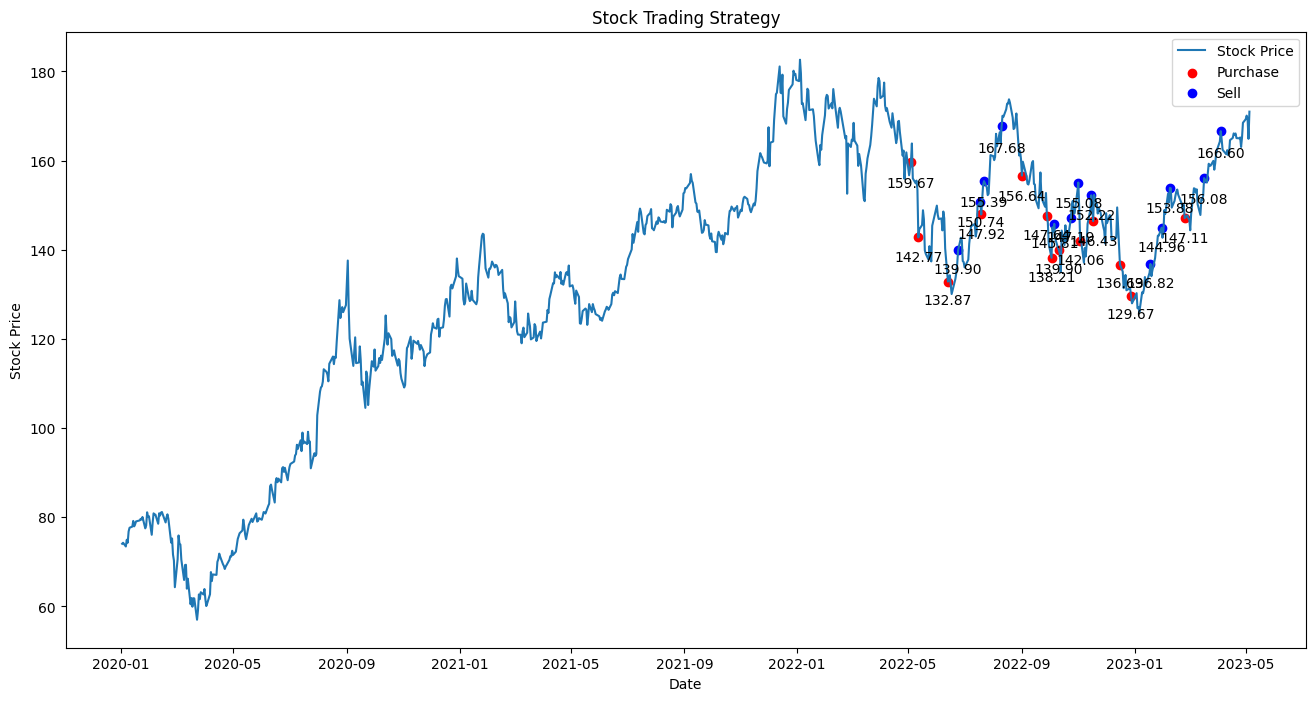

In [13]:
plot_trading_strategy(stock_df, result)